# Librerías

In [ ]:
!pip install adversarial-robustness-toolbox

In [ ]:

import tensorflow as tf
import numpy as np
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical


In [ ]:
import matplotlib.pyplot as plt

# Cargar datos

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/tmp/out-231024.csv')
# print(dataset)

In [ ]:
from sklearn.model_selection import train_test_split
def CargarYprepararDatos(data):
    #data['Pre_static_analysis.Filename'] = data['Pre_static_analysis.Filename'].str.split('.').str[0]
    test = data.apply(pd.to_numeric, errors='coerce')
    data = test
    X = data.drop("malware", axis=1)
    y = data["malware"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test


In [ ]:
X_train, X_test, y_train, y_test = CargarYprepararDatos(dataset)

# Convertir a numpy

In [ ]:
#X_train
import pandas as pd
import numpy as np
np_X_train = X_train.to_numpy()
np_X_test = X_test.to_numpy()
np_y_train = y_train.to_numpy()
np_y_test = y_test.to_numpy()

In [ ]:
# Prueba - To_categorical => https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical => Cambia la forma en la que entran los datos, se rompe en modelo
# X_train = to_categorical(X_train, 2)
# X_test = to_categorical(X_test, 2)
# y_train = to_categorical(y_train, 2)
# y_test = to_categorical(y_test, 2)
print(np_X_train)

[[1 1 1 ... 1 0 0]
 [1 1 1 ... 1 0 0]
 [1 0 0 ... 1 0 0]
 ...
 [1 1 1 ... 1 0 0]
 [1 1 1 ... 1 0 0]
 [0 1 0 ... 1 0 0]]


In [ ]:

#print(X_test)
print(len(np_y_train))

342


# Modelo

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - acc: 0.6202 - loss: 1.3044
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - acc: 0.9277 - loss: 0.2103
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - acc: 0.9674 - loss: 0.0970
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - acc: 0.9870 - loss: 0.0476
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - acc: 0.9911 - loss: 0.0339
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - acc: 0.9945 - loss: 0.0248
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - acc: 0.9978 - loss: 0.0178
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - acc: 0.9978 - loss: 0.0133
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - acc: 1.0000 - loss: 0.0122
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - acc: 1.0000 - loss: 0.0054


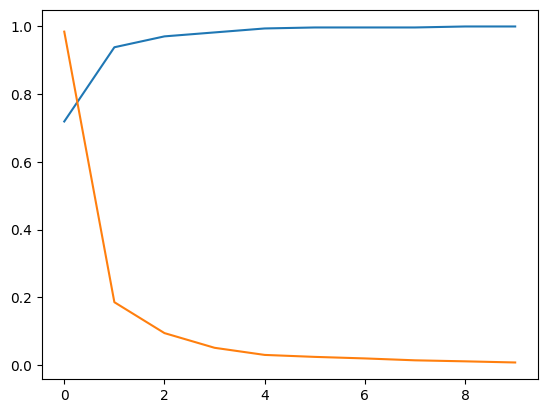

In [ ]:


model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=342, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid')) # Antes: Softmax

opt = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

# hist = model.fit(X_train, y_train, verbose=True, epochs=10)
hist = model.fit(np_X_train, np_y_train, verbose=True, epochs=10)
plt.plot(hist.history['acc'])
plt.plot(hist.history['loss'])
plt.show()

# Ataque 1 = Generar muestras adversarias con FGSM

In [ ]:
# Crear un clasificador ART a partir del modelo de TensorFlow
classifier = TensorFlowV2Classifier(
    model=model,
    input_shape=1,
    clip_values=(0, 1),
    nb_classes=2,
    loss_object=tf.keras.losses.CategoricalCrossentropy()
)

# Evaluar el modelo en los datos de prueba limpios
predictions = np.argmax(classifier.predict(np_X_test), axis=1)

In [ ]:
print(len(y_test))
print(np.argmax(y_test))

86
0


In [ ]:
accuracy = np.sum(predictions == np.argmax(np_y_test)) / len(np_y_test)
print(f"Precisión en datos de prueba: {accuracy * 100:.2f}%")

attack = FastGradientMethod(estimator=classifier, eps=0.25)
x_test_adv = attack.generate(x=np_X_test)


Precisión en datos de prueba: 100.00%


/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(32, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(22, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


In [ ]:
x_test_adv

array([[1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.]], dtype=float32)

In [ ]:

# Evaluar el modelo en los datos adversarios
predictions_adv = np.argmax(classifier.predict(x_test_adv))
accuracy_adv = np.sum(predictions_adv == np.argmax(np_y_test)) / len(np_y_test)
print(f"Precisión en datos adversarios: {accuracy_adv * 100:.2f}%")

# Comparar predicciones antes y después del ataque
print("Predicciones en muestras limpias:", predictions)
print("Predicciones en muestras con FGSM:", predictions_adv)


Precisión en datos adversarios: 0.00%
Predicciones en muestras limpias: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
Predicciones en muestras con FGSM: 8


In [ ]:
print(len(x_test_adv))
print(accuracy_adv)

86
0.0


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.5154 - loss: 4.1125 


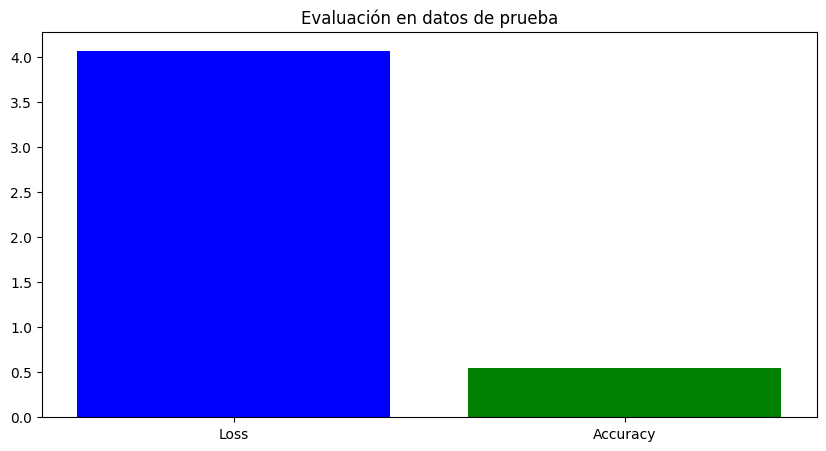

In [ ]:
array_zeros = np.zeros(86, dtype=int)


# Evaluar el modelo y graficar la pérdida y precisión
history_test = model.evaluate(x_test_adv, array_zeros, verbose=True)

# Graficar la pérdida y precisión
plt.figure(figsize=(10, 5))
plt.bar(["Loss", "Accuracy"], history_test, color=["blue", "green"])
plt.title("Evaluación en datos de prueba")
plt.show()

# Ataque 2 - BasicIterativeMethod

In [ ]:
# Crear un clasificador ART a partir del modelo de TensorFlow
classifier2 = TensorFlowV2Classifier(
    model=model,
    input_shape=1,
    clip_values=(0, 1),
    nb_classes=2,
    loss_object=tf.keras.losses.CategoricalCrossentropy()
)

# Evaluar el modelo en los datos de prueba limpios
predictions2 = np.argmax(classifier.predict(np_X_test), axis=1)


In [ ]:
from art.attacks.evasion import BasicIterativeMethod

In [ ]:
accuracy2 = np.sum(predictions2 == np.argmax(np_y_test)) / len(np_y_test)
print(f"Precisión en datos de prueba: {accuracy2 * 100:.2f}%")

attack2 = BasicIterativeMethod(estimator=classifier2)
x_test_adv2 = attack2.generate(x=np_X_test)


Precisión en datos de prueba: 100.00%


PGD - Batches: 0it [00:00, ?it/s]

In [ ]:
print(len(x_test_adv2))

86


In [ ]:

df_x_test_adv2 = pd.DataFrame(x_test_adv2)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.5154 - loss: 4.1125


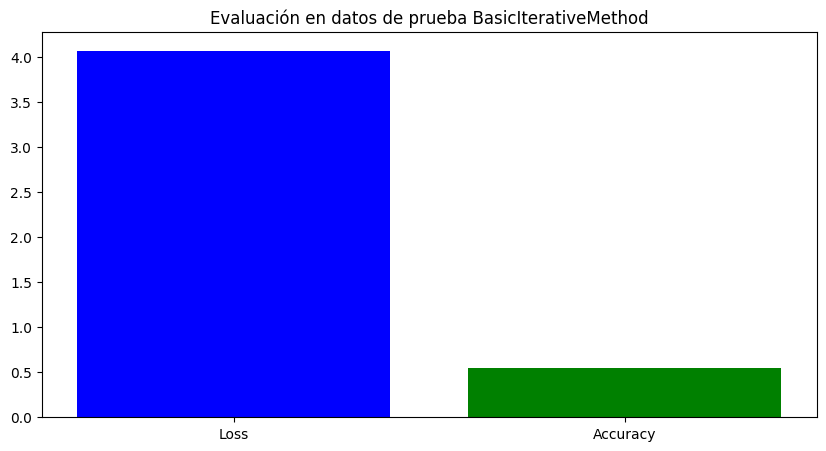

In [ ]:
array_zeros = np.zeros(86, dtype=int)


# Evaluar el modelo y graficar la pérdida y precisión
history_test2 = model.evaluate(x_test_adv2, array_zeros, verbose=True)

# Graficar la pérdida y precisión
plt.figure(figsize=(10, 5))
plt.bar(["Loss", "Accuracy"], history_test2, color=["blue", "green"])
plt.title("Evaluación en datos de prueba BasicIterativeMethod")
plt.show()

# Ataque 3 - ProjectedGradientDescent

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent

In [ ]:
# Crear un clasificador ART a partir del modelo de TensorFlow
classifier3 = TensorFlowV2Classifier(
    model=model,
    input_shape=1,
    clip_values=(0, 1),
    nb_classes=2,
    loss_object=tf.keras.losses.CategoricalCrossentropy()
)

# Evaluar el modelo en los datos de prueba limpios
predictions3 = np.argmax(classifier3.predict(np_X_test), axis=1)


accuracy3 = np.sum(predictions3 == np.argmax(np_y_test)) / len(np_y_test)
print(f"Precisión en datos de prueba: {accuracy3 * 100:.2f}%")

attack3 = ProjectedGradientDescent(estimator=classifier3)
x_test_adv3 = attack3.generate(x=np_X_test)
df_x_test_adv3 = pd.DataFrame(x_test_adv3)


Precisión en datos de prueba: 100.00%


PGD - Batches: 0it [00:00, ?it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.5154 - loss: 4.1125


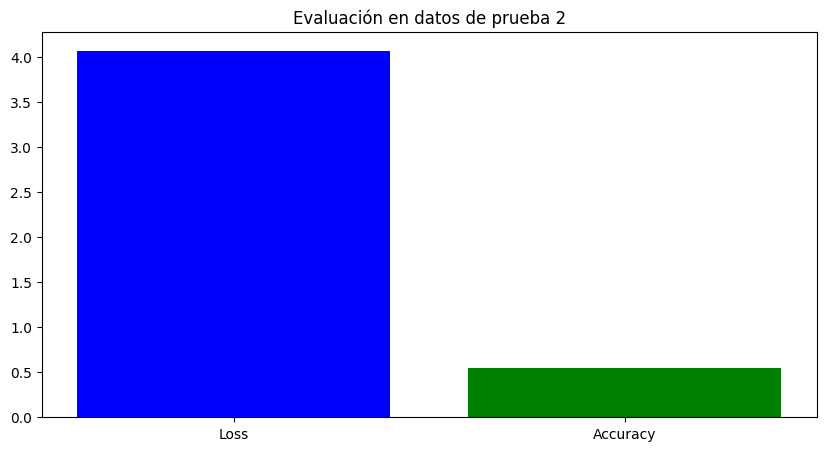

In [ ]:


# Evaluar el modelo y graficar la pérdida y precisión
history_test3 = model.evaluate(x_test_adv3, array_zeros, verbose=True)

# Graficar la pérdida y precisión
plt.figure(figsize=(10, 5))
plt.bar(["Loss", "Accuracy"], history_test3, color=["blue", "green"])
plt.title("Evaluación en datos de prueba 2")
plt.show()

In [ ]:
#from art.attacks.evasion import SaliencyMapMethod # Da un error: InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/

# Ataque 4 - ZOO - Error: Casting

In [ ]:
# from art.attacks.evasion import DeepFool
# from art.attacks.evasion import CarliniLInfMethod
# from art.attacks.evasion import CarliniL2Method # Error:
# ValueError: This attack has not yet been tested for binary classification with a single output classifier.

In [ ]:
from art.attacks.evasion import ZooAttack


In [ ]:
model.add(tf.keras.layers.Dense(2, activation="softmax"))

In [ ]:

# Validar la forma de los datos de entrada
print("Forma de x_test:", np_X_test.shape)

Forma de x_test: (86, 10138)


In [ ]:
# Crear un clasificador ART a partir del modelo de TensorFlow
classifier5 = TensorFlowV2Classifier(
     model=model,  # Tu modelo TensorFlow/Keras
    input_shape=(10138,),  # 10138 características por muestra
    clip_values=(0, 1),  # Rango de valores de entrada (por ejemplo, imágenes normalizadas)
    nb_classes=2,  # Número de clases en el modelo
    loss_object=tf.keras.losses.CategoricalCrossentropy()
)

# Configurar el ataque ZOO
attack5 = ZooAttack(
    classifier=classifier5,
    confidence=0.0,  # Confianza deseada en los ejemplos adversarios
    targeted=False,  # Es un ataque no dirigido (no seleccionamos una clase específica como objetivo)
    learning_rate=0.01,  # Tasa de aprendizaje
    max_iter=10,  # Número máximo de iteraciones
    binary_search_steps=5,  # Número de pasos para búsqueda binaria
    initial_const=0.01,  # Constante inicial de ataque
    abort_early=True  # Finaliza antes si no hay progreso
)

np_X_test= np_X_test.astype('float64')

# Generar ejemplos adversarios
x_test_adv5 = attack5.generate(x=np_X_test)

# # Evaluar el modelo en los datos de prueba limpios
# predictions5 = np.argmax(classifier5.predict(np_X_test), axis=1)


# accuracy5 = np.sum(predictions3 == np.argmax(np_y_test)) / len(np_y_test)
# print(f"Precisión en datos de prueba: {accuracy5 * 100:.2f}%")

# attack5 = ZooAttack(classifier=classifier5)
# x_test_adv5 = attack5.generate(x=np_X_test)
# df_x_test_adv5 = pd.DataFrame(x_test_adv5)


ZOO:   0%|          | 0/86 [00:00<?, ?it/s]

In [ ]:
df_x_test_adv5 = pd.DataFrame(x_test_adv5)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.5154 - loss: 4.1125


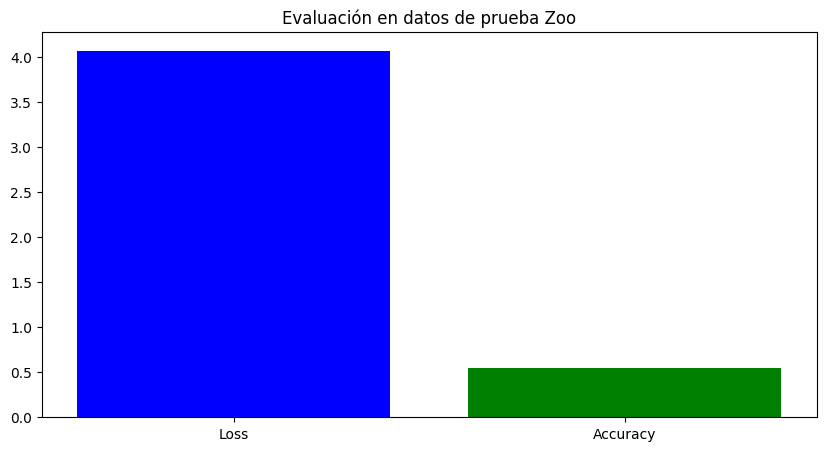

In [ ]:


# Evaluar el modelo y graficar la pérdida y precisión
history_test5 = model.evaluate(x_test_adv5, array_zeros, verbose=True)

# Graficar la pérdida y precisión
plt.figure(figsize=(10, 5))
plt.bar(["Loss", "Accuracy"], history_test5, color=["blue", "green"])
plt.title("Evaluación en datos de prueba Zoo")
plt.show()

# Ataque 5 - DeepFool

In [ ]:
from art.attacks.evasion import DeepFool

In [ ]:
# Crear un clasificador ART a partir del modelo de TensorFlow
classifier4 = TensorFlowV2Classifier(
    model=model,
    input_shape=1,
    clip_values=(0, 1),
    nb_classes=2,
    loss_object=tf.keras.losses.CategoricalCrossentropy()
)

# Evaluar el modelo en los datos de prueba limpios
predictions4 = np.argmax(classifier4.predict(np_X_test), axis=1)


accuracy4 = np.sum(predictions4 == np.argmax(np_y_test)) / len(np_y_test)
print(f"Precisión en datos de prueba: {accuracy4 * 100:.2f}%")

attack4 = DeepFool(classifier=classifier4)
x_test_adv4 = attack4.generate(x=np_X_test)
df_x_test_adv4 = pd.DataFrame(x_test_adv4)


Precisión en datos de prueba: 100.00%


DeepFool:   0%|          | 0/86 [00:00<?, ?it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.9825 - loss: 0.3027


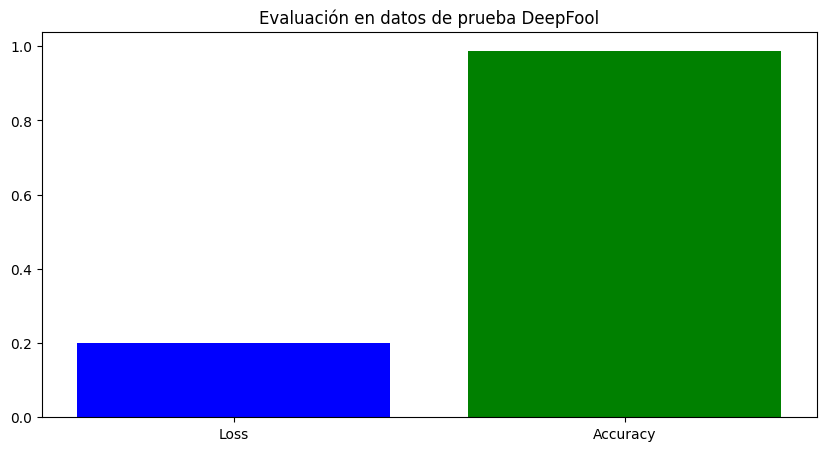

In [ ]:


# Evaluar el modelo y graficar la pérdida y precisión
history_test4 = model.evaluate(x_test_adv4, array_zeros, verbose=True)

# Graficar la pérdida y precisión
plt.figure(figsize=(10, 5))
plt.bar(["Loss", "Accuracy"], history_test4, color=["blue", "green"])
plt.title("Evaluación en datos de prueba DeepFool")
plt.show()

# Ataque 6 - CarliniL2Method

In [ ]:
from art.attacks.evasion import CarliniL2Method

In [ ]:
# Crear un clasificador ART a partir del modelo de TensorFlow
classifier6 = TensorFlowV2Classifier(
    model=model,
    input_shape=len(np_X_test),
    clip_values=(0, 1),
    nb_classes=2,
    loss_object=tf.keras.losses.CategoricalCrossentropy()
)

# Evaluar el modelo en los datos de prueba limpios
predictions6 = np.argmax(classifier6.predict(np_X_test), axis=1)


accuracy6 = np.sum(predictions6 == np.argmax(np_y_test)) / len(np_y_test)
print(f"Precisión en datos de prueba: {accuracy6 * 100:.2f}%")

attack6 = CarliniL2Method(classifier=classifier6)
x_test_adv6 = attack6.generate(x=np_X_test)
df_x_test_adv6 = pd.DataFrame(x_test_adv6)


Precisión en datos de prueba: 100.00%


C&W L_2:   0%|          | 0/86 [00:00<?, ?it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.5154 - loss: 4.1125 


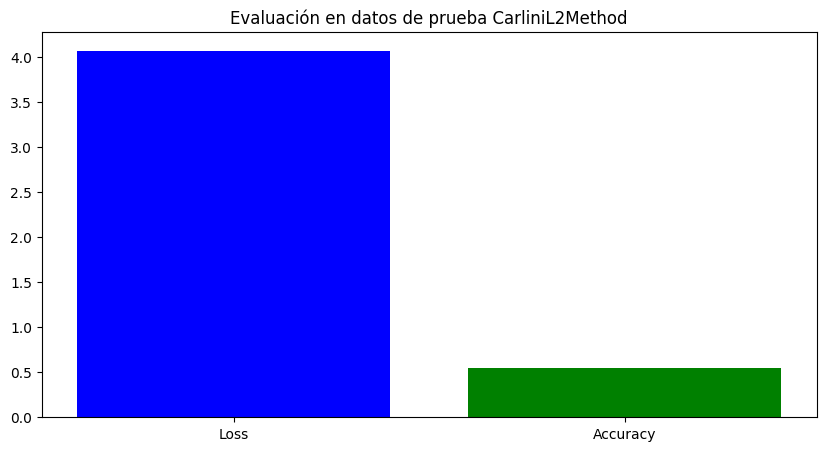

In [ ]:


# Evaluar el modelo y graficar la pérdida y precisión
history_test6 = model.evaluate(x_test_adv6, array_zeros, verbose=True)

# Graficar la pérdida y precisión
plt.figure(figsize=(10, 5))
plt.bar(["Loss", "Accuracy"], history_test6, color=["blue", "green"])
plt.title("Evaluación en datos de prueba CarliniL2Method")
plt.show()

# Ataque 7 - CarliniLInfMethod

In [ ]:
from art.attacks.evasion import CarliniLInfMethod

In [ ]:
# Crear un clasificador ART a partir del modelo de TensorFlow
classifier7 = TensorFlowV2Classifier(
    model=model,
    input_shape=len(np_X_test),
    clip_values=(0, 1),
    nb_classes=2,
    loss_object=tf.keras.losses.CategoricalCrossentropy()
)

# Evaluar el modelo en los datos de prueba limpios
predictions7 = np.argmax(classifier7.predict(np_X_test), axis=1)


accuracy7 = np.sum(predictions7 == np.argmax(np_y_test)) / len(np_y_test)
print(f"Precisión en datos de prueba: {accuracy7 * 100:.2f}%")

attack7 = CarliniLInfMethod(classifier=classifier7)
x_test_adv7 = attack7.generate(x=np_X_test)
df_x_test_adv7 = pd.DataFrame(x_test_adv7)


Precisión en datos de prueba: 100.00%


C&W L_inf:   0%|          | 0/86 [00:00<?, ?it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.5154 - loss: 4.1125 


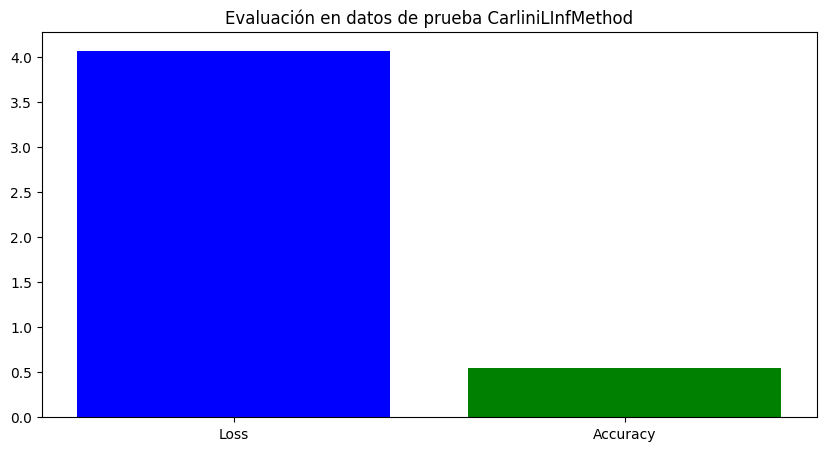

In [ ]:


# Evaluar el modelo y graficar la pérdida y precisión
history_test7 = model.evaluate(x_test_adv7, array_zeros, verbose=True)

# Graficar la pérdida y precisión
plt.figure(figsize=(10, 5))
plt.bar(["Loss", "Accuracy"], history_test7, color=["blue", "green"])
plt.title("Evaluación en datos de prueba CarliniLInfMethod")
plt.show()

# Ataque 8 - BoundaryAttack

In [ ]:
from art.attacks.evasion import BoundaryAttack

In [ ]:
# Crear un clasificador ART a partir del modelo de TensorFlow
classifier8 = TensorFlowV2Classifier(
    model=model,
    input_shape=len(np_X_test),
    clip_values=(0, 1),
    nb_classes=2,
    loss_object=tf.keras.losses.CategoricalCrossentropy()
)

# Evaluar el modelo en los datos de prueba limpios
predictions8 = np.argmax(classifier8.predict(np_X_test), axis=1)


accuracy8 = np.sum(predictions8 == np.argmax(np_y_test)) / len(np_y_test)
print(f"Precisión en datos de prueba: {accuracy8 * 100:.2f}%")

attack8 = BoundaryAttack(estimator=classifier8)
x_test_adv8 = attack8.generate(x=np_X_test, y=array_zeros)
df_x_test_adv8 = pd.DataFrame(x_test_adv8)


Precisión en datos de prueba: 100.00%


Boundary attack:   0%|          | 0/86 [00:00<?, ?it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.5154 - loss: 4.1125


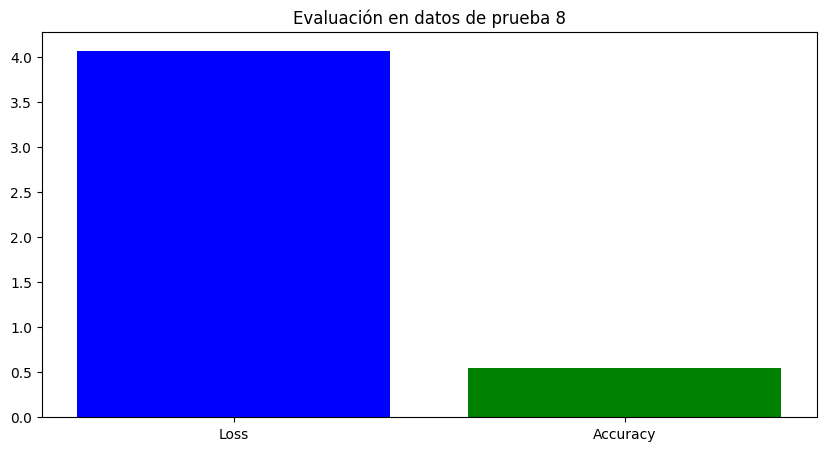

In [ ]:


# Evaluar el modelo y graficar la pérdida y precisión
history_test8 = model.evaluate(x_test_adv8, array_zeros, verbose=True)

# Graficar la pérdida y precisión
plt.figure(figsize=(10, 5))
plt.bar(["Loss", "Accuracy"], history_test8, color=["blue", "green"])
plt.title("Evaluación en datos de prueba 8")
plt.show()

# Ataque 9 - HopSkipJump

In [ ]:
# from art.attacks.evasion import AdversarialPatch # Error: TypeError: object of type 'int' has no len()
# from art.attacks.evasion import DecisionTreeAttack # EstimatorError: DecisionTreeAttack requires an estimator derived from <class 'art.estimators.classification.scikitlearn.ScikitlearnDecisionTreeClassifier'>
from art.attacks.evasion import HopSkipJump

In [ ]:
# Crear un clasificador ART a partir del modelo de TensorFlow
classifier9 = TensorFlowV2Classifier(
    model=model,
    input_shape=len(np_X_test),
    clip_values=(0, 1),
    nb_classes=2,
    loss_object=tf.keras.losses.CategoricalCrossentropy()
)

# Evaluar el modelo en los datos de prueba limpios
predictions9 = np.argmax(classifier9.predict(np_X_test), axis=1)


accuracy9 = np.sum(predictions8 == np.argmax(np_y_test)) / len(np_y_test)
print(f"Precisión en datos de prueba: {accuracy9 * 100:.2f}%")

attack9 = HopSkipJump(classifier=classifier9)
x_test_adv9 = attack9.generate(x=np_X_test, y=array_zeros)
df_x_test_adv9 = pd.DataFrame(x_test_adv9)


Precisión en datos de prueba: 100.00%


HopSkipJump:   0%|          | 0/86 [00:00<?, ?it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.5154 - loss: 4.1125


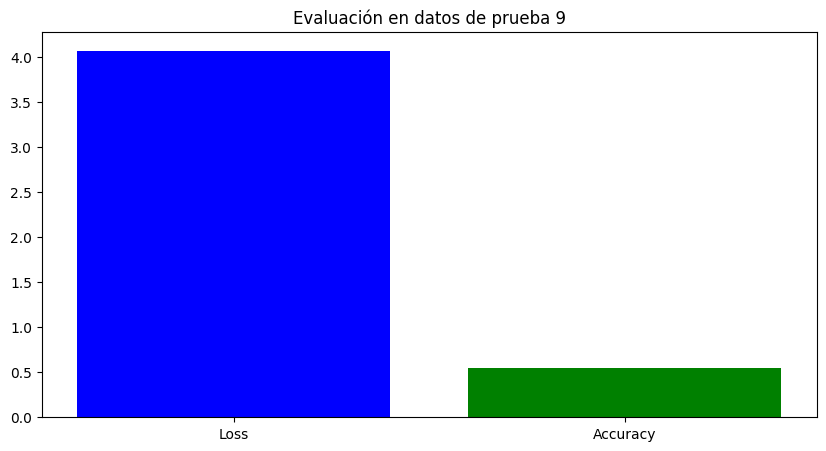

In [ ]:


# Evaluar el modelo y graficar la pérdida y precisión
history_test9 = model.evaluate(x_test_adv9, array_zeros, verbose=True)

# Graficar la pérdida y precisión
plt.figure(figsize=(10, 5))
plt.bar(["Loss", "Accuracy"], history_test9, color=["blue", "green"])
plt.title("Evaluación en datos de prueba 9")
plt.show()

# Ataque 10 - SaliencyMapMethod

In [ ]:
from art.attacks.evasion import SaliencyMapMethod

In [ ]:
# Crear un clasificador ART a partir del modelo de TensorFlow
classifier10 = TensorFlowV2Classifier(
    model=model,
    input_shape=len(np_X_test),
    clip_values=(0, 1),
    nb_classes=2,
    loss_object=tf.keras.losses.CategoricalCrossentropy()
)

# Evaluar el modelo en los datos de prueba limpios
predictions10 = np.argmax(classifier10.predict(np_X_test), axis=1)


accuracy10 = np.sum(predictions8 == np.argmax(np_y_test)) / len(np_y_test)
print(f"Precisión en datos de prueba: {accuracy10 * 100:.2f}%")

attack10 = SaliencyMapMethod(classifier=classifier10)
x_test_adv10 = attack10.generate(x=np_X_test, y=array_zeros)
df_x_test_adv10 = pd.DataFrame(x_test_adv10)


Precisión en datos de prueba: 100.00%


<ipython-input-55-ab43397f2666>:18: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  x_test_adv10 = attack10.generate(x=np_X_test, y=array_zeros)


JSMA:   0%|          | 0/86 [00:00<?, ?it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.5154 - loss: 4.1125 


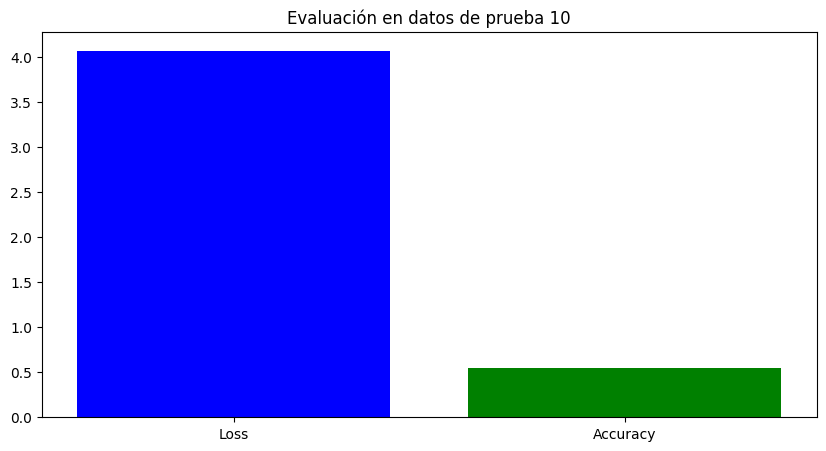

In [ ]:


# Evaluar el modelo y graficar la pérdida y precisión
history_test10 = model.evaluate(x_test_adv10, array_zeros, verbose=True)

# Graficar la pérdida y precisión
plt.figure(figsize=(10, 5))
plt.bar(["Loss", "Accuracy"], history_test10, color=["blue", "green"])
plt.title("Evaluación en datos de prueba 10")
plt.show()

# Modelo núm 2 - Error


In [ ]:
# len(np_X_train)

In [ ]:
# model2 = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(10138, 10138)),
#   tf.keras.layers.Dense(342, activation='relu'),
#   tf.keras.layers.Dense(188, activation='relu'),
#   tf.keras.layers.Dense(58, activation='relu'),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(2, activation='sigmoid')
# ])
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# model2.compile(optimizer='adam',
#               loss=loss_fn,
#               metrics=['acc'])

# hist2 = model2.fit(np_X_train, np_y_train, verbose=True, epochs=15)
# plt.plot(hist2.history['acc'])
# plt.plot(hist2.history['loss'])
# plt.show()

In [ ]:
# # Crear un clasificador ART a partir del modelo de TensorFlow
# classifier2B = TensorFlowV2Classifier(
#     model=model2,
#     input_shape=(len(np_X_test),),
#     clip_values=(0, 1),
#     nb_classes=2,
#     loss_object=tf.keras.losses.BinaryCrossentropy()
# )

# # Evaluar el modelo en los datos de prueba limpios
# predictions2B = np.argmax(classifier2B.predict(np_X_test), axis=1)

In [ ]:
# accuracy2B = np.sum(predictions2B == np.argmax(np_y_test)) / len(np_y_test)
# print(f"Precisión en datos de prueba: {accuracy2B * 100:.2f}%")

# attack2B = FastGradientMethod(estimator=classifier2B, eps=0.95)
# x_test_adv2B = attack2B.generate(x=np_X_test)


# Guardar en un archivo

In [ ]:
print(type(dataset))

428


In [ ]:
dataset.columns[-1]

titulos_cols = dataset.columns.values.tolist()
#titulos_cols = dataset.columns.values.tolist()

print(len(titulos_cols))

10139


In [ ]:


df_x_test_adv = pd.DataFrame(x_test_adv)
all_attacks = pd.concat([df_x_test_adv, df_x_test_adv2], ignore_index=True)

all_attacks = pd.concat([all_attacks, df_x_test_adv3], ignore_index=True)
all_attacks = pd.concat([all_attacks, df_x_test_adv4], ignore_index=True)
all_attacks = pd.concat([all_attacks, df_x_test_adv5], ignore_index=True)

all_attacks = pd.concat([all_attacks, df_x_test_adv6], ignore_index=True)
all_attacks = pd.concat([all_attacks, df_x_test_adv7], ignore_index=True)
all_attacks = pd.concat([all_attacks, df_x_test_adv8], ignore_index=True)
all_attacks = pd.concat([all_attacks, df_x_test_adv9], ignore_index=True)
all_attacks = pd.concat([all_attacks, df_x_test_adv10], ignore_index=True)
# Guardar el DataFrame en un archivo CSV
all_attacks.to_csv("adversarial_data.csv", index=False, header=False)

In [ ]:
all_attacks.columns = titulos_cols

ValueError: Length mismatch: Expected axis has 10138 elements, new values have 10139 elements

In [ ]:
print(len(all_attacks))